In [1]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\Users\New\Anaconda3\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Reading in data
# ==============================================================================
building3=pd.read_csv('Building3.csv')

In [4]:
#Converting to Datetime objects
# ==============================================================================
building3['datetime']=pd.to_datetime(building3['datetime'], format='%d/%m/%Y %H:%M')
building3= building3.set_index('datetime')
building3= building3.asfreq('H')

In [5]:
building3

,X,Unnamed..0,series_name,Year,Month,Day_of_Month,Week,Day,Hour,series_value,NumericMonth
datetime,,,,,,,,,,,
2016-03-01 15:00:00,52318.0,52318.0,Building3,2016.0,Mar,1.0,9.0,2.0,15.0,1321.00,3.0
2016-03-01 16:00:00,52319.0,52319.0,Building3,2016.0,Mar,1.0,9.0,2.0,16.0,1300.00,3.0
2016-03-01 17:00:00,52320.0,52320.0,Building3,2016.0,Mar,1.0,9.0,2.0,17.0,1260.00,3.0
2016-03-01 18:00:00,52321.0,52321.0,Building3,2016.0,Mar,1.0,9.0,2.0,18.0,1156.00,3.0
2016-03-01 19:00:00,52322.0,52322.0,Building3,2016.0,Mar,1.0,9.0,2.0,19.0,801.00,3.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-10-01 05:00:00,92504.0,92504.0,Building3,2020.0,Oct,1.0,40.0,4.0,5.0,237.50,10.0
2020-10-01 06:00:00,92505.0,92505.0,Building3,2020.0,Oct,1.0,40.0,4.0,6.0,250.00,10.0
2020-10-01 07:00:00,92506.0,92506.0,Building3,2020.0,Oct,1.0,40.0,4.0,7.0,378.50,10.0


In [6]:
#Split Train-Val for Buildings
# ==============================================================================
end_train='2018-12-31 23:00'
start_val='2019-01-01 00:00'
end_val='2019-12-31 23:00'
start_test='2020-01-01 00:00'

building3train=building3.loc[:end_train, :]
building3val=building3.loc[start_val:end_val, :]
building3test=building3.loc[start_test:, :]


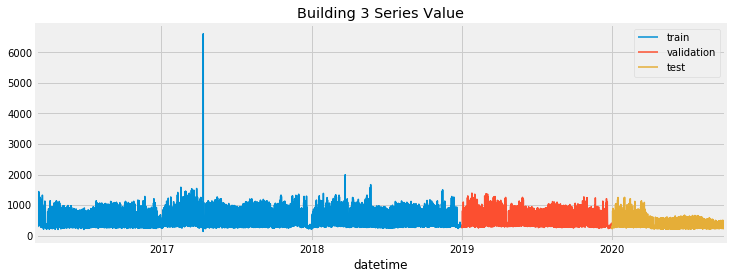

In [7]:
# Plot time series
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
building3train['series_value'].plot(ax=ax, label='train')
building3val['series_value'].plot(ax=ax, label='validation')
building3test['series_value'].plot(ax=ax, label='test')
ax.set_title('Building 3 Series Value')
ax.legend();

In [8]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags = 24
                )

forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2022-09-20 00:38:34 
Last fit date: None 
Skforecast version: 0.4.3 

In [10]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = building3.loc[:end_val, 'series_value'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(building3train)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop lags_grid:   0%|                                               | 0/4 [00:00<?, ?it/s]


Exception: `y` has missing values.

In [13]:
building3['series_value'].isnull().sum()

4

In [14]:
building3[building3['series_value'].isna()]

,X,Unnamed..0,series_name,Year,Month,Day_of_Month,Week,Day,Hour,series_value,NumericMonth
datetime,,,,,,,,,,,
2016-10-02 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-07 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-06 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = building1['series_value'],
    initial_train_size = len(building1.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False
    )

print(f"Backtest error: {metric}")